In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import os 
from numpy import random
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin # For the constructor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve

### Load Data

In [2]:
current_working_directory = os.getcwd()

train_data  = np.loadtxt(current_working_directory + "\\data\\train.txt", dtype = float)
test_data  = np.loadtxt(current_working_directory + "\\data\\test.txt", dtype = float)

print("Train data shape: {}".format(train_data.shape))
print("Test data shape: {}".format(test_data.shape))

Train data shape: (7291, 257)
Test data shape: (2007, 257)


##### Important Note: The jupyter notebook and the data folder must be in the same directory.
First we load our data.

We have 7291 samples in our training data set and 2007 samples in our test data set. <br> 
The first column in both data sets is the digit that the sample represents.



### Create data sets

In [3]:
# The first column is the label and the others are the features.
X_train = train_data[:, 1:]
y_train = train_data[:, 0]


X_test = test_data[:, 1:]
y_test = test_data[:, 0]

print("Train data shape: {}\nTrain labels shape: {}".format(X_train.shape, y_train.shape))
print("Test data shape: {}\nTest labels shape: {}".format(X_test.shape, y_test.shape))

Train data shape: (7291, 256)
Train labels shape: (7291,)
Test data shape: (2007, 256)
Test labels shape: (2007,)


## Plot some digits

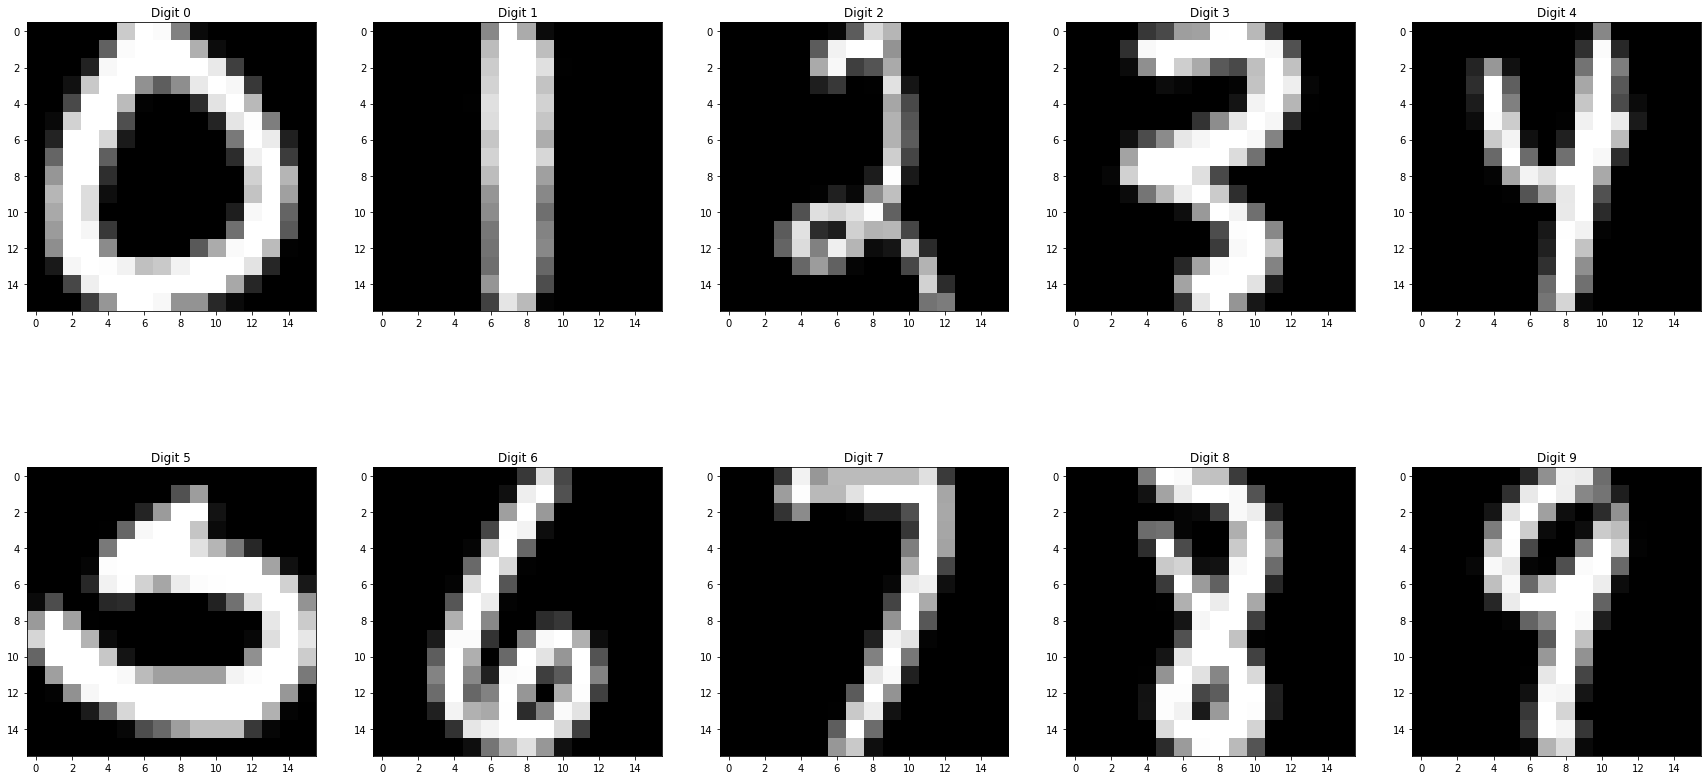

In [4]:
# Create a list with a random index for every digit.
random_indices = [random.choice(np.where(y_train == digit)[0]) for digit in range(10)]

# Plot one image for every digit.
figure, axs = plt.subplots(2, 5, figsize = (30, 15))
for i in range(10):
    current_digit_image = X_train[random_indices[i], :].reshape(16, 16) # convert the random sample to an image.
    axs[i // 5, i % 5].set_title("Digit {}".format(i))
    axs[i // 5, i % 5].imshow(current_digit_image, cmap = "gray")

# Compute mean and variance

In [5]:
# A function that creates a dataset with the samples from one specific label(digit) and computes the mean value from every feature.
def compute_mean(X, y, digit):
    indices = np.where(y == digit)[0] # find the indices that correspond to the digit.
    digit_X = X[indices] # Create an array with the samples that correspond to the digit label.
    return np.mean(digit_X, axis = 0) # Compiute the mean in every feature (column)

# A function that creates a dataset with the samples from one specific label(digit) and computes the variance value from every feature.
def compute_variance(X, y, digit):
    indices = np.where(y == digit)[0] # find the indices that correspond to the digit.
    digit_X = X[indices] # Create an array with the samples that correspond to the digit label.
    return np.var(digit_X, axis = 0) # Compiute the variance in every feature (column)

In [6]:
# A list with all the mean vectors for every digit.
mean_digits = [compute_mean(X_train, y_train, digit) for digit in range(10)]
# A list with all the variance vectors for every digit.
variance_digits = [compute_variance(X_train, y_train, digit) for digit in range(10)]

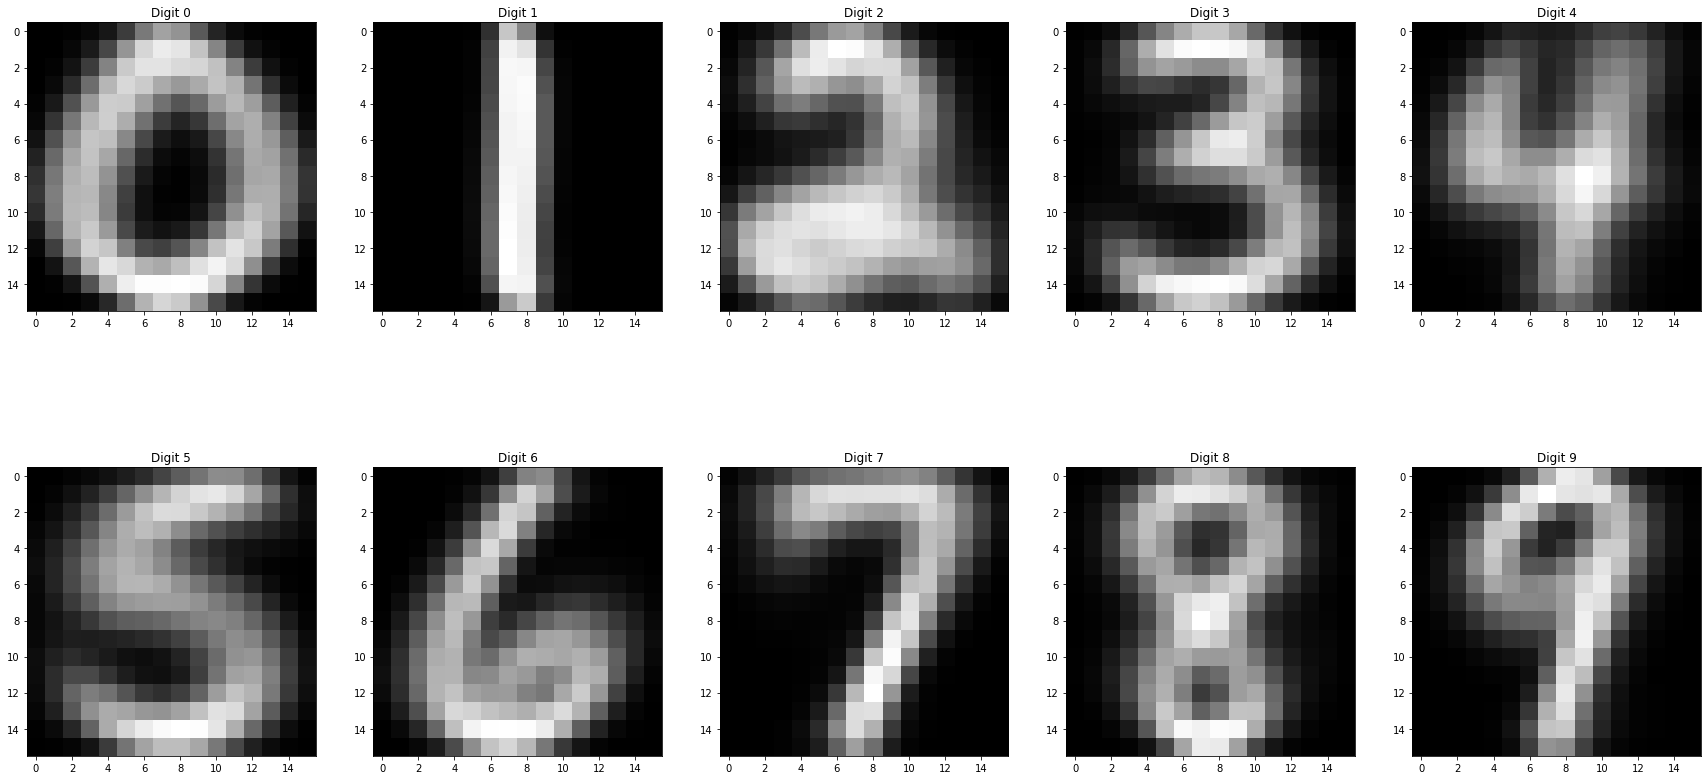

In [7]:
# Plot one image for every digit.
figure, axs = plt.subplots(2, 5, figsize = (30, 15))
for i in range(10):
    current_digit_image = mean_digits[i].reshape(16, 16) # convert the random sample to an image.
    axs[i // 5, i % 5].set_title("Digit {}".format(i))
    axs[i // 5, i % 5].imshow(current_digit_image, cmap = "gray")

# Create Euclidean Classifier

- For every label(digit) computes the mean value in every feature(column). So we have a vector with 256 feature for every label
- Then for every new sample, computes the euclidean distance between the sample and all the means and classifies this sample to the class with the min euclidean distance.

In [8]:
class EuclideanClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self):
        self.X_mean = None
        self.classes = None
    
    # fit: computes the means.
    def fit(self, X, y):
        # The classes that exist in the current y data set.
        self.classes = np.unique(y).astype(int)
        
        self.X_mean = np.zeros((len(self.classes), X.shape[1]))
        for index, current_class in enumerate(self.classes):
            self.X_mean[index, :] = compute_mean(X, y, current_class)
        return self
    
    # predict: computes the y_predictions
    # For every sample in test data:
    #  Compute the euclidean distance between the sample and the means.
    #  Compute the minimum euclidean distance which corresponds to the predicted class and store it to y_predictions.
    def predict(self, X):
        y_predictions = []
        for i in range(len(X)):
            euclidean_distances_list = [np.linalg.norm(X[i] - self.X_mean[digit]) for digit in range(len(self.classes))]
            y_predictions.append(np.argmin(euclidean_distances_list))
        return np.array(y_predictions)
    
    # score: computes the accuracy.
    def score(self, X, y):
        y_predictions = self.predict(X)
        return accuracy_score(y, y_predictions)

In [11]:
euclidean_clf_model = EuclideanClassifier()
euclidean_clf_model.fit(X_train, y_train)
euclidean_clf_model_test_accuracy = euclidean_clf_model.score(X_test, y_test)
print("Euclidean classifier test accuracy: {}%".format(euclidean_clf_model_test_accuracy*100))

Euclidean classifier test accuracy: 81.41504733432984%


In [12]:
# 5 fold cross validation 
scores = cross_val_score(EuclideanClassifier(), X_train, y_train, cv = KFold(n_splits=5, random_state = 42, shuffle = True), scoring = "accuracy")
print('Accuracy on each of the 5 splits: {}'.format(scores))
print("CV Average Accuracy: {}".format(np.mean(scores)))

Accuracy on each of the 5 splits: [0.8560658  0.83058985 0.85871056 0.84636488 0.85802469]
CV Average Accuracy: 0.8499511569549394


# Decision Boundaries

In [13]:
# A function that plots decision regions.
def plot_clf(clf, X, y, labels, plot_labels):
    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of Classifier')
    
    # Initializations
    # X0: Skeleton area
    # X1: Skeleton variance
    X0, X1 = X[:,0], X[:,1]
    
    x_min, x_max = X0.min() - 0.2, X0.max() + 0.2
    y_min, y_max = X1.min() - 0.2, X1.max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                         np.arange(y_min, y_max, .05))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    
    colors = ['red', 'yellow', 'blue', 'green', 'black', 'purple', 'orange', 'silver', 'grey', 'brown']  
    
    for label in labels:
        ax.scatter(
            X0[y == label], X1[y == label],
            c=(colors[int(label)]), label=int(label),
            s=60, alpha=0.9, edgecolors='k'
        )
    
    ax.set_ylabel(plot_labels[1])
    ax.set_xlabel(plot_labels[0])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

In [14]:
pca_object = PCA(n_components = 2)

X_train_pca = pca_object.fit_transform(X_train)

euclidean_clf_pca_model = EuclideanClassifier()
euclidean_clf_pca_model.fit(X_train_pca, y_train)

EuclideanClassifier()

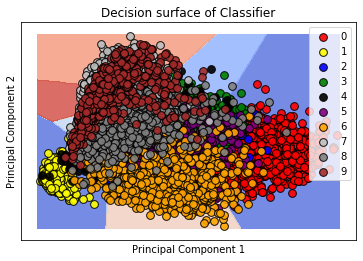

In [17]:
plot_clf(euclidean_clf_pca_model, X_train_pca, y_train, euclidean_clf_pca_model.classes, ["Principal Component 1", "Principal Component 2"])

# Learning Curves

In [18]:
def plot_learning_curve(train_scores, test_scores, train_sizes, ylim=(0, 1)):
    plt.figure()
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [19]:
train_sizes, train_scores, test_scores = learning_curve(
    EuclideanClassifier(), 
    X_train, 
    y_train, 
    cv = 5, 
    n_jobs = -1, 
    train_sizes = np.linspace(.1, 1.0, 5)
)

<module 'matplotlib.pyplot' from 'C:\\Users\\plust\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

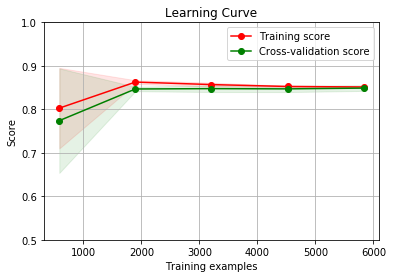

In [20]:
plot_learning_curve(train_scores, test_scores, train_sizes, ylim = (0.5, 1))

Learning curve is a tool to find out how much a model benefits from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, it will not benefit much from more training data.

From the graph above, we observe the following:
- Initially, when the training set consists of few data, our model has a high training score and a lower cross-validation score, which is also logical since with a small training set the model is as if learning only those specific data of the training set and does not generalize as well to unknown data.
- As the size of the training set grows, we notice that the training score and the cross-validation score converge, so the model has a better generalization ability. It is worth noting that there is no notable improvement after 4000 examples in the training set.


# Create Naive Bayes Classifier

In [21]:
def compute_gaussian_prob(X, X_mean, X_variance):
    numerator = np.exp(((X - X_mean)**2/X_variance)*(-0.5))
    denominator = np.sqrt(2*np.pi*X_variance)
    return numerator/denominator

In [22]:
class NaiveBayesClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self):
        self.a_prior_probs = None
        self.X_mean = None
        self.X_variance = None
        self.classes = None
    
    # fit: computes a-prior probs, means and variances for every digit.
    def fit(self, X, y, calculate_variance = True):
        # The classes that exist in the current y data set.
        self.classes = np.unique(y).astype(int)
        
        self.a_prior_probs = [len(np.where(y == digit)[0])/len(y) for digit in range(len(self.classes))]
        
        self.X_mean = np.zeros((len(self.classes), X.shape[1]))
        self.X_variance = np.ones((len(self.classes), X.shape[1]))
        for index, current_class in enumerate(self.classes):
            self.X_mean[index, :] = compute_mean(X, y, current_class)
            if(calculate_variance):
                self.X_variance[index, :] = compute_variance(X, y, current_class)
        self.X_variance[self.X_variance == 0] += 1e-10 # Add a very small number so that I do not have zero division in the future.

        return self
    
    # predict: computes the y_predictions
    def predict(self, X):
        gaussian_probs = np.zeros((len(X), len(self.classes)))
                
        for digit in range(len(self.classes)):
            gaussian_probs[:, digit] = np.prod(compute_gaussian_prob(X, self.X_mean[digit], self.X_variance[digit]), axis = 1)*self.a_prior_probs[digit]
        
        return np.argmax(gaussian_probs, axis = 1)
    
    # score: computes the accuracy.
    def score(self, X, y):
        y_predictions = self.predict(X)
        return accuracy_score(y, y_predictions)

In [23]:
naive_bayes_clf_model = NaiveBayesClassifier()
naive_bayes_clf_model.fit(X_train, y_train, True)
naive_bayes_clf_model_accuracy = naive_bayes_clf_model.score(X_test, y_test)
print("Naive Bayes Classifier Accuracy: {}".format(naive_bayes_clf_model_accuracy))

C:\Users\plust\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\plust\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Naive Bayes Classifier Accuracy: 0.7144992526158446


# MLP using PyTorch

In [28]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

### Create DataLoaders

In [25]:
# Transform numpy arrays to tensors.
tensor_X_train = torch.Tensor(X_train) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train)

tensor_X_test = torch.Tensor(X_test) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test)

In [26]:
# Create DataLoaders
train_dataset = TensorDataset(tensor_X_train, tensor_y_train) 
train_loader = DataLoader(train_dataset, batch_size = 64)

### Create an MLP

In [58]:
class MLP(nn.Module):
    def __init__(self, layers_sizes_lst, output_layer_size = 10):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers_sizes_lst)-1):
            self.layers.append(nn.Linear(layers_sizes_lst[i], layers_sizes_lst[i+1]))
        self.layers.append(nn.Linear(layers_sizes_lst[-1], output_layer_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        out = F.softmax(self.layers[-1](x))
        return out    

In [62]:
def compute_mlp_accuracy(predicted_labels, actual_labels):
    accuracy = torch.sum(predicted_labels == actual_labels)/actual_labels.size()[0]
    return accuracy.item()

def train_model(model, train_data, train_labels):
    # Set train mode.
    model.train()
    
    # Sets the gradients to zero before we start backpropagation
    optimizer.zero_grad()
    
    # Forward pass - compute labels.
    predicted_train_labels = model(data)
    
    # Calculate cross entropy loss.
    loss = loss_function(predicted_train_labels, train_labels)
    
    # Computes the gradients.
    loss.backward()
    
    # Update the parameters.
    optimizer.step()
    
    return loss.item()

def test_model(model, data, actual_labels):
    # Set evaluation mode.
    model.eval()
    
    # Compute predicted labels.
    predicted_test_labels = torch.argmax(model(data), axis = 1)
    
    # Compute accuracy.
    final_accuracy = compute_mlp_accuracy(predicted_test_labels, actual_labels)
    
    return final_accuracy

In [63]:
# Create an MLP with 1 input layer(size = 256) 2 hidden layers(sizes = 512 & 256) and 1 output layer(size = 10) 
mlp = MLP([256, 512, 256], 10)

loss_function = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(mlp.parameters(), lr = learning_rate)

In [64]:
number_of_epochs = 10
training_loss = []
for epoch in range(number_of_epochs):
    for data, label in train_loader:
        training_loss.append(train_model(mlp, data, label.type(torch.LongTensor)))
    print("Epoch: {} - Loss: {}".format(epoch, training_loss[epoch]))
    
mlp_accuracy = test_model(mlp, tensor_X_test, tensor_y_test)
print("MLP Accuracy: {}".format(mlp_accuracy))

C:\Users\plust\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Epoch: 0 - Loss: 2.303741455078125
Epoch: 1 - Loss: 2.29040789604187
Epoch: 2 - Loss: 2.270514488220215
Epoch: 3 - Loss: 2.24914288520813
Epoch: 4 - Loss: 2.2087717056274414
Epoch: 5 - Loss: 2.1919031143188477
Epoch: 6 - Loss: 2.1031134128570557
Epoch: 7 - Loss: 2.0633957386016846
Epoch: 8 - Loss: 2.0904972553253174
Epoch: 9 - Loss: 2.054412364959717
MLP Accuracy: 0.8659691214561462
